# Univariate Time Series Forecasting with Exogenous Variables

In this set of notebooks, we will cover modeling with exogenous variables. Our plan of action is as follows:

1. Perform EDA on the dataset to extract valuable insight about the process generating the time series. **(Covered in this notebook)**
2. Build a baseline model (univariable model without exogenous variables) for benchmarking purposes.
3. Build a univariate model with all exogenous variables to check best possible performance.
4. Evaluate the model with exogenous variables and discuss any potential issues.
5. Overcome issues identified above.
6. Make future predictions with the best model.
7. Replicate flow with Automated Time Series Modeling (AutoML)

In [1]:
# Only enable critical logging (Optional)
import os
os.environ["PYCARET_CUSTOM_LOGGING_LEVEL"] = "CRITICAL"

In [2]:
def what_is_installed():
    from pycaret import show_versions
    show_versions()

try:
    what_is_installed()
except ModuleNotFoundError:
    !pip install pycaret
    what_is_installed()


System:
    python: 3.9.16 (main, Jan 11 2023, 16:16:36) [MSC v.1916 64 bit (AMD64)]
executable: C:\Users\Nikhil\.conda\envs\pycaret_dev_sktime_16p1\python.exe
   machine: Windows-10-10.0.19044-SP0

PyCaret required dependencies:
                 pip: 22.3.1
          setuptools: 65.6.3
             pycaret: 3.0.0rc9
             IPython: 8.10.0
          ipywidgets: 8.0.4
                tqdm: 4.64.1
               numpy: 1.23.5
              pandas: 1.5.3
              jinja2: 3.1.2
               scipy: 1.10.0
              joblib: 1.2.0
             sklearn: 1.2.1
                pyod: 1.0.8
            imblearn: 0.10.1
   category_encoders: 2.6.0
            lightgbm: 3.3.5
               numba: 0.56.4
            requests: 2.28.2
          matplotlib: 3.7.0
          scikitplot: 0.3.7
         yellowbrick: 1.5
              plotly: 5.13.0
             kaleido: 0.2.1
         statsmodels: 0.13.5
              sktime: 0.16.1
               tbats: 1.1.2
            pmdarima: 2.0.2


In [3]:
import numpy as np
import pandas as pd
from pycaret.datasets import get_data
from pycaret.time_series import TSForecastingExperiment

In [4]:
# Global Figure Settings for notebook ----
# Depending on whether you are using jupyter notebook, jupyter lab, Google Colab, you may have to set the renderer appropriately
global_fig_settings = {
    # "renderer": "notebook",
    "width": 1000,
    "height": 600,
}

In [5]:
data = get_data("airquality")
data["index"] = pd.to_datetime(data["Date"] + " " + data["Time"])
data.drop(columns=["Date", "Time"], inplace=True)
target = "CO(GT)"

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,2004-03-10,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,2004-03-10,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,2004-03-10,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,2004-03-10,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888


**The dataset has missing values tagged as -200. [Reference](https://archive.ics.uci.edu/ml/datasets/air+quality). We should remove these values (replace them with NaN) and let `pycaret` handle the imputation appropriately (preventing leakage of data during training).**

In [6]:
data[data[target] == -200].head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,index
10,-200.0,1011,14,1.3,527,21,1818,34,1197,445,10.1,60.5,0.7465,2004-03-11 04:00:00
34,-200.0,831,10,1.1,506,21,1893,32,1134,384,6.1,65.9,0.6248,2004-03-12 04:00:00
39,-200.0,1545,-200,22.1,1353,-200,767,-200,2058,1588,9.2,56.2,0.6561,2004-03-12 09:00:00
58,-200.0,1147,56,6.2,821,109,1132,83,1412,992,7.0,71.1,0.7158,2004-03-13 04:00:00
82,-200.0,1130,56,5.2,773,70,1130,82,1452,1051,12.1,61.1,0.8603,2004-03-14 04:00:00


In [7]:
data.replace(-200, np.nan, inplace=True)
data[data[target] == -200]

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,index


Now, let's go on to our EDA and modeling. 

# Exploratory Analysis

In [8]:
# Create an EDA experiment ----
eda = TSForecastingExperiment()

In [9]:
eda.setup(
    data=data,
    target=target,
    index="index",
    fh=48,
    numeric_imputation_target="ffill",
    numeric_imputation_exogenous="ffill",
    # Set defaults for the plots ----
    fig_kwargs=global_fig_settings,
    session_id=42,
)

,Description,Value
0,session_id,42
1,Target,CO(GT)
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(9357, 13)"
5,Transformed data shape,"(9357, 13)"
6,Transformed train set shape,"(9309, 13)"
7,Transformed test set shape,"(48, 13)"
8,Rows with missing values,91.2%
9,Fold Generator,ExpandingWindowSplitter


Even before proceeding, we can observe some useful information here.

1. The data is an hourly dataset, hence a seasonal period of 24 was tested. Seasonality was detected at this time period.
2. While modeling, it is recommended that the data be differenced (d=1) due to the nature of the data. We will evaluate this further during the EDA process.

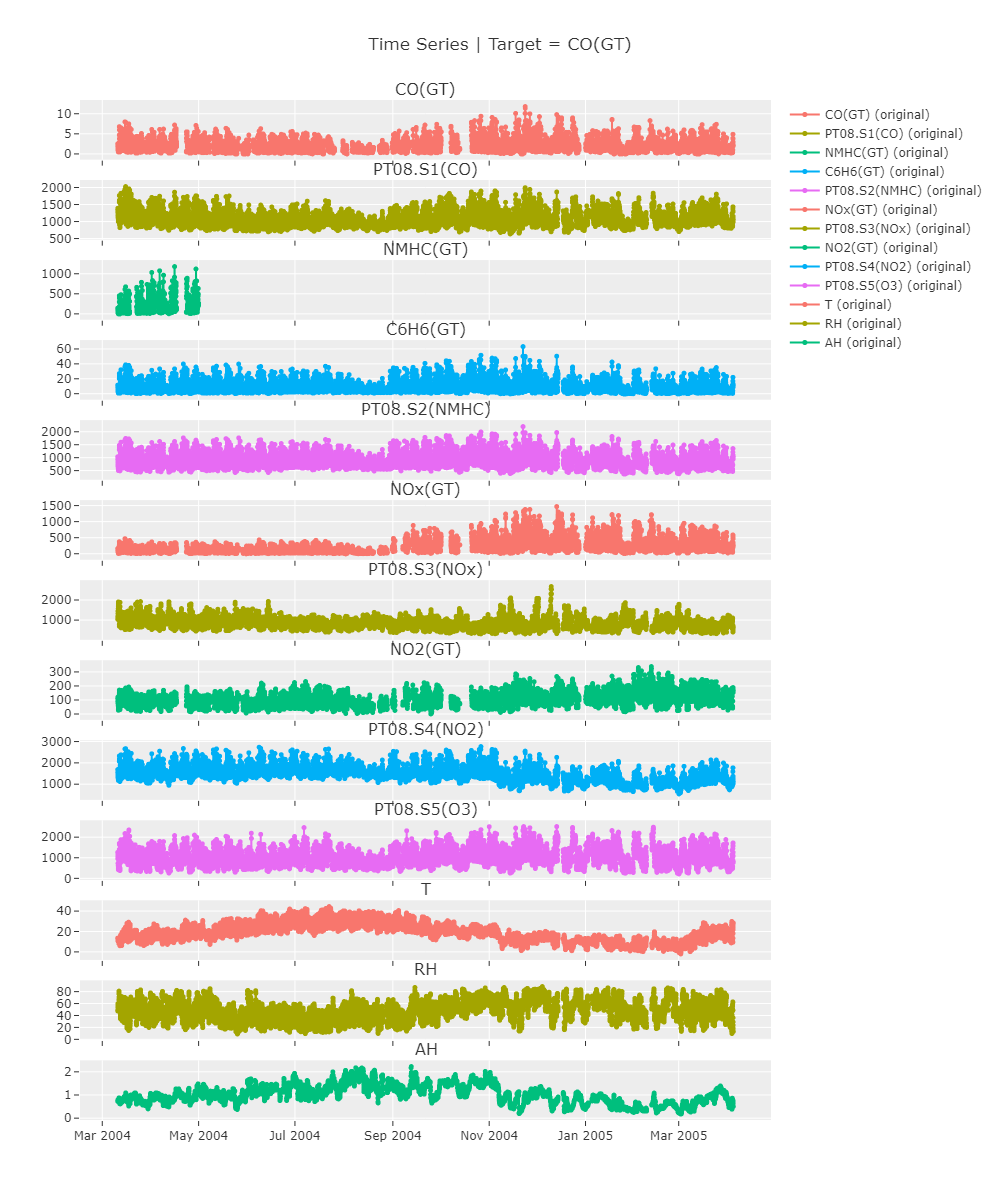

In [10]:
# Plot the target variable along with any exogenous variables ----
# Becasue the data is quite huge, plotting an interactive plot can slow down the notebook.
# Hence, we will revert to a static renderer for this plot
eda.plot_model(fig_kwargs={"renderer": "png", "width": 1000, "height": 1200})

In [11]:
# However, when you use the display_format `plotly-dash` or `plotly-widget`, 
# The plotly-resampler toolkit will be used as visualization back-end.
# This makes the plotly-visualization snappy and interactive by allowing data-aggregation 
# when you zoom in/out, datapoints are re-rendered for the region of interest.
eda.plot_model(
    plot="ts",
    fig_kwargs={
        'height': 1200,
        # With resampler_kwargs, the constructor of the plotly-resampler object
        # can be configured.
        "resampler_kwargs": {
            "default_n_shown_samples": 1500,
            # show_dash kwargs withholds the kwargs of the show_dash (render) method.
            "show_dash": {"mode": "inline", "port": 8055},
        },
    },
    display_format="plotly-dash",
)

While it may be hard to see the details in the zoomed out plot, pycaret provides the ability to zoom in using interactive plotly plots. On zooming in, a clear 24 hour cycle is visiable with peaks around 19:00 and at 8:00.

Also it looks like `NMHC(GT)` has all missing values. We will remove this for any multivariate models that we develop in the future.

Next, the setup recommended that the data should be differenced. Let's see what this looks like and if it is necessary. In addition to the differenced data, we will also plot some diagnostics such as ACF, PACF and Periodogram. While many readers will be aware of ACF and PACF, some more light may need to be shed on the periodogram. Periodogram is a plot that plots the spectral density in a time series as a function of frequency. The frequency in yhis case ranges from 0 to 0.5 (Minimum points required to measure a frequency is 2 which corresponds to a max frequency of 0.5). The magnitude at the various frequencies can be used to derive important characteristics about the time series. We will see this below.

In [12]:
exclude = ["NMHC(GT)"]

In [13]:
# Plots original data with first difference (order d = 1) by default
eda.plot_model(
    plot="diff",
    fig_kwargs={
        "height": 900,
        # No need to pass show_dash kwargs when using a plotly-widget
        "resampler_kwargs": {"default_n_shown_samples": 1500 }
    },
    data_kwargs={"acf": True, "pacf": True, "periodogram": True},
    display_format="plotly-widget",
)


FigureWidgetResampler({
    'data': [{'line': {'color': 'rgb(31, 119, 180)', 'width': 2},
              'marker': {'color': 'rgb(31, 119, 180)', 'size': 5},
              'mode': 'lines+markers',
              'name': '<b style="color:sandybrown">[R]</b> Actual <i style="color:#fc9944">~6h</i>',
              'showlegend': False,
              'type': 'scattergl',
              'uid': '9453eb53-220b-4802-b808-ef743c7aa9d4',
              'x': array([datetime.datetime(2004, 3, 10, 18, 0),
                          datetime.datetime(2004, 3, 10, 23, 0),
                          datetime.datetime(2004, 3, 11, 4, 0), ...,
                          datetime.datetime(2005, 4, 4, 4, 0),
                          datetime.datetime(2005, 4, 4, 8, 0),
                          datetime.datetime(2005, 4, 4, 14, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([2.6, 1.2, 0.6, ..., 0.4, 5. , 2.2]),
              'yaxis': 'y'},
             {'line': {'color': '#3f3f3f'},
   

The plots above show some interesting characteristics.

**Original**
1. Do we need differencing? 
  - The dataset shows extended autocorrelations (ACF - row 1, col 2) which are well above the significance level. This points to the need for differencing.
  - The same observation can be derived by looking at the PACF plot as well (row 1 col 3) which shows a very high correlation on lag 1 (i.e. previous time point).
  - This characteristic can also be seen in the Periodogram (row 1, col 4) which shows a peak at ~ f = 0 (zoom in to see details). Peaking at ~ f = 0 means that the time period is very large (no repetitions) and is indicative of "random walk" type of behavior that can be modeling by differencing.
2. Do we need to model seasonality?
  - ACF also shows peaking at a lag of 24 indicative of seasonality of 24 (which was also indicated in the setup phase). 
  - This can also be seen in the periodogram (peaking at a fundamental f = 0.0417 (and it's harmonics of 0.0834,  0.1249 ...). f = 0.0417 corresponds to T = 1/0.0417 = 24 indicating a seasonal period of 24 hours.

**Order = 1 Difference**
1. Order = 1 differencing shows that a lot of the extended autocorrelations have been taken care of (magnitide in row 2, col 2 is much less than before). The same is visible in the periodogram (row 2, col 4) where the magnitide at ~ f = 0 is much less than before.
2. ACF still shows peaking at a lag = 24 and so does the periodogram indicating that we still need to take care of this to model the behavior appropriately. Let's do that next by plotting the differences including the seasonality. This time, we will specify the lags explicitly as we want more finer control over the analysis.

NOTE: lags = 1 is same as order = 1 meaning first difference, whereas lags = [1, 24] implies that first a first difference is taken and then a seasonal difference of 24 is taken.

In [14]:
eda.plot_model(
    plot="diff",
    fig_kwargs={
        "height": 900,
        "resampler_kwargs": {
            "default_n_shown_samples": 1500,
            "show_dash": {"mode": "inline", "port": 8056},
        },
    },
    data_kwargs={
        "lags_list": [1, [1, 24]],
        "acf": True,
        "pacf": True,
        "periodogram": True,
    },
    display_format='plotly-dash',
)


We will bring our attention to the 3rd row since the first 2 are the repeat of the last plot. The 3rd row represents a first order difference followed by a seasonal difference of 24. As can be see from the ACF (row 3, col 2), all the extended autocorrelations have been taken care of. We still see a peak at lag = 24 (negative now), but on careful examination of the periodogram, we realize that the leaks have a very low spectral density. Hence, we can conclude that taking the first difference and a seasonal difference of 24 can model this time series fairly reasonably. However

NOTE: The reader may choose to investigate this further to figure our the AR and MA components. For example, the PACF plot (row 3, col 3) shows a negative spike (significant) at lag = 2 and further, indicating at least a second order AR component. For the sake of simplicity, we will not use that for this execise, but it should definitely be explored for a more complete assessment.

Next, lets explore the effect of the exogenous variables on the target and the correlation between the. This can be accomplished with the help of Cross Correlation Plots.

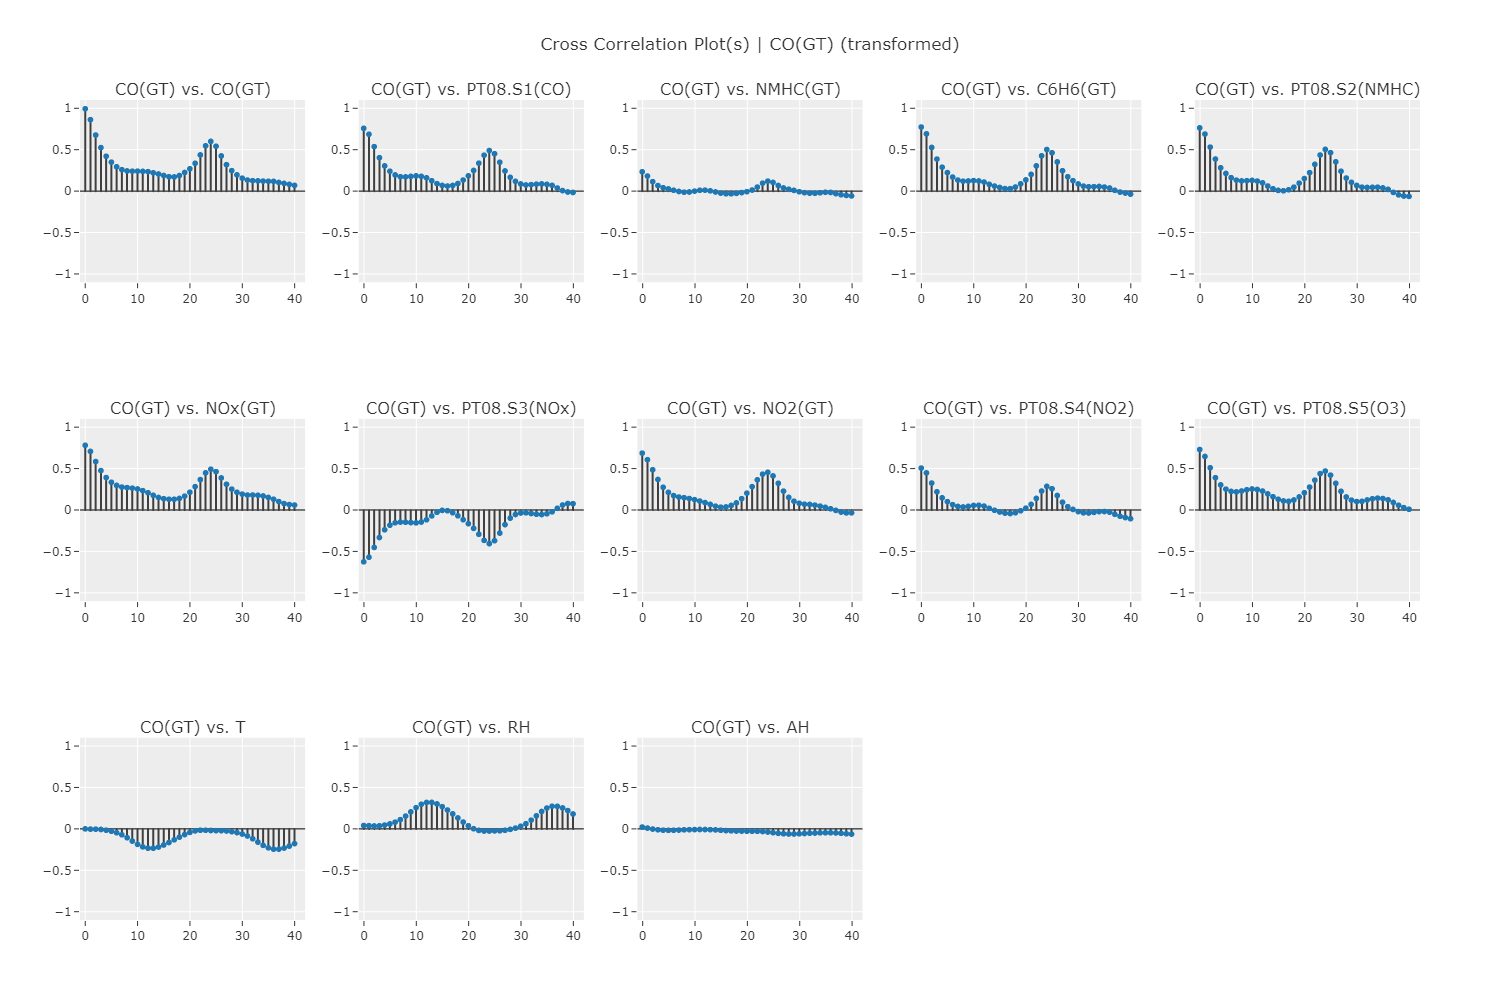

In [15]:
eda.plot_model(plot="ccf", fig_kwargs={"height": 1000, "width": 1500})

The first plot (row 1, col 1) shows self correlation for the target (same as its ACF), while the rest of the plots show the correlation of the target to the lagged values of the exogenous variables. For example, row 1, col 2 shows that the CO concentration is heavily correlated with `PT08.S1(CO)` at lag 0 as well as at lag 24. A similar pattern can be ovserved for some of the other variables as well such as `NOx(GT)`, `C6H6(GT)`, `PT08.S2(NMHC)`. These variables may come in handy when modeling the CO concentration. 

Another ovbservation is that Absolute Humidity `AH` does not seem to have a very strong correlation with CO concentration. This variable may not be important for modeling.

In [16]:
exclude.append("AH")
exclude

['NMHC(GT)', 'AH']